Using the SOXS Python interface, this example shows how to generate photons from two thermal spectra and two $\beta$-model spatial distributions, as an approximation of two galaxy clusters. 

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rc("font", size=16, family="serif")
import matplotlib.pyplot as plt
import soxs

We want to generate thermal spectra, so we first create a spectral generator using the ``ApecGenerator`` class:

In [2]:
emin = 0.05 # keV
emax = 20.0 # keV
nbins = 20000 
agen = soxs.ApecGenerator(emin, emax, nbins)

Next, we'll generate the two thermal spectra. We'll set the APEC norm for each to 1, and renormalize them later:

In [3]:
kT1 = 6.0
abund1 = 0.3
redshift1 = 0.05
norm1 = 1.0
spec1 = agen.get_spectrum(kT1, abund1, redshift1, norm1)

In [4]:
kT2 = 4.0
abund2 = 0.4
redshift2 = 0.1
norm2 = 1.0
spec2 = agen.get_spectrum(kT2, abund2, redshift2, norm2)

Now, re-normalize the spectra using energy fluxes between 0.5-2.0 keV:

In [5]:
flux1 = 1.0e-13 # erg/s/cm**2
flux2 = 5.0e-14 # erg/s/cm**2
emin = 0.5 # keV
emax = 2.0 # keV
spec1.rescale_flux(flux1, emin=0.5, emax=2.0, flux_type="energy")
spec2.rescale_flux(flux2, emin=0.5, emax=2.0, flux_type="energy")

We'll also apply foreground galactic absorption to each spectrum:

In [6]:
n_H = 0.04 # 10^20 atoms/cm^2
spec1.apply_foreground_absorption(n_H)
spec2.apply_foreground_absorption(n_H)

``spec1`` and ``spec2`` are ``Spectrum`` objects. Let's have a look at the spectra:

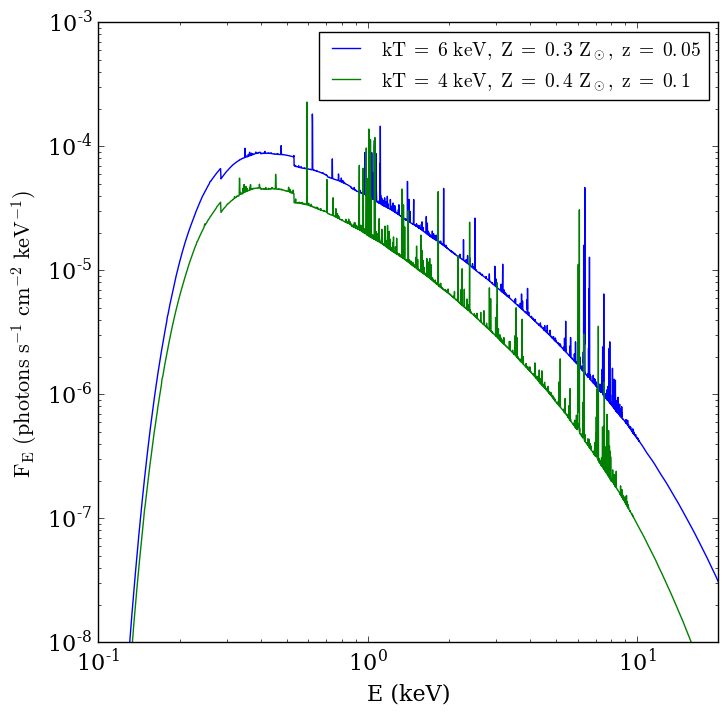

In [7]:
plt.figure(figsize=(8, 8))
plt.loglog(spec1.emid, spec1.flux, label="$\mathrm{kT\ =\ 6\ keV,\ Z\ =\ 0.3\ Z_\odot,\ z\ =\ 0.05}$")
plt.loglog(spec2.emid, spec2.flux, label="$\mathrm{kT\ =\ 4\ keV,\ Z\ =\ 0.4\ Z_\odot,\ z\ =\ 0.1}$")
plt.xlim(0.1, 20.0)
plt.ylim(1.0e-8, 1.0e-3)
plt.xlabel("E (keV)")
plt.ylabel("$\mathrm{F_E\ (photons\ s^{-1}\ cm^{-2}\ keV^{-1})}$")
plt.legend(fontsize=14)

Now, what we want to do is generate energies from these spectra. We want to create a large sample that we'll draw from when we run the instrument simulator, so choose a large exposure time and a large collecting area (should be bigger than the maximum of the ARF):

In [8]:
t_exp = 500000.0 # in s
area = 30000.0 # in cm^2
e1 = spec1.generate_energies(t_exp, area)
e2 = spec2.generate_energies(t_exp, area)

soxs: [INFO     ] 2016-10-27 12:06:21,184 Creating 1538147 events from this spectrum.
soxs: [INFO     ] 2016-10-27 12:06:21,396 Creating 727769 events from this spectrum.


Now that we have the energies, we need to generate the positions for each cluster using a $\beta$-model. For that, we use the ``BetaModel`` class:

In [9]:
num_events1 = e1.size
num_events2 = e2.size

# Parameters for the clusters
r_c1 = 20.0 # in arcsec
r_c2 = 30.0 # in arcsec
beta1 = 1.0
beta2 = 2.0/3.0

# Center of the field of view
ra0 = 30.0 # degrees
dec0 = 45.0 # degrees

# Space the clusters roughly a few arcminutes apart on the sky. 
# They're at different redshifts, so one is behind the other.
dx = 3.0/60.0 # degrees
ra1 = ra0 - 0.5*dx
dec1 = dec0 - 0.5*dx
ra2 = ra0 + 0.5*dx
dec2 = dec0 + 0.5*dx

# Now actually create the distributions
cluster1 = soxs.BetaModel(ra1, dec1, r_c1, beta1, num_events1)
cluster2 = soxs.BetaModel(ra2, dec2, r_c2, beta2, num_events2)

We can quickly show the positions using a scatter plot. For simplicity, we'll only show every 100th event, and restrict ourselves to a roughly 20"x20" field of view. 

Just a warning: the clusters are going to look a bit distorted because we did the "right thing" when we created the positions and generated their coordinates with the tangent projection, but we are not taking account of that when we make the scatter plot. Everything will look correct in the final event file. 

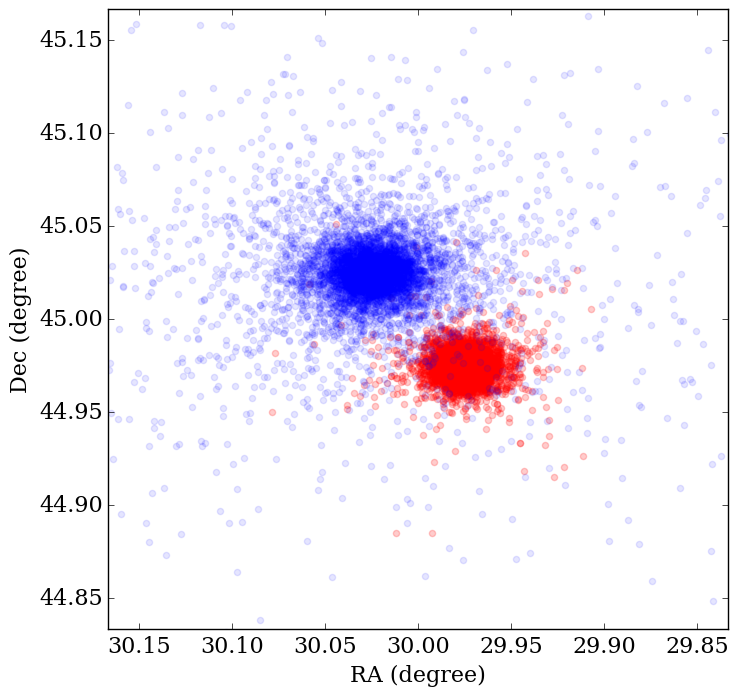

In [10]:
plt.figure(figsize=(8.0, 8.0))
plt.scatter(cluster1.ra[::100], cluster1.dec[::100], color='r', alpha=0.2)
plt.scatter(cluster2.ra[::100], cluster2.dec[::100], color='b', alpha=0.1)
plt.xlim(ra0+1./6., ra0-1./6.)
plt.ylim(dec0-1./6., dec0+1./6.)
plt.xlabel("RA (degree)")
plt.ylabel("Dec (degree)")

Now that we have the positions and the energies of the photons, we can write them to a SIMPUT catalog, using ``write_photon_list``. Each cluster will have its own photon list, but be part of the same SIMPUT catalog. We have to supply the exposure time and area we used here so that the SIMPUT catalog knows what the flux of each source is:

In [11]:
# Create the SIMPUT catalog "clusters" and the photon list "cluster1"
soxs.write_photon_list("clusters", "cluster1", t_exp, area, cluster1.ra, cluster1.dec, e1, clobber=True)
# Append the photon list "cluster2" to the same SIMPUT catalog
soxs.write_photon_list("clusters", "cluster2", t_exp, area, cluster2.ra, cluster2.dec, e2, append=True, clobber=True)

Finally, we can use the instrument simulator to simulate the two clusters by ingesting the SIMPUT file, setting an output file "evt.fits", setting an exposure time of 50 ks (less than the one we used to generate the source), the "hdxi" instrument, and the pointing direction of (RA, Dec) = (30.,45.) degrees.

In [12]:
soxs.instrument_simulator("clusters_simput.fits", "evt.fits", 50000.0, "hdxi", [30., 45.], clobber=True)

soxs: [INFO     ] 2016-10-27 12:06:23,593 Detecting events from source 1
soxs: [INFO     ] 2016-10-27 12:06:23,594 Applying energy-dependent effective area from xrs_hdxi.arf.
soxs: [INFO     ] 2016-10-27 12:06:23,745 67237 events detected.
soxs: [INFO     ] 2016-10-27 12:06:23,762 Pixeling events.
soxs: [INFO     ] 2016-10-27 12:06:23,796 1 events were rejected because they fall outside the field of view.
soxs: [INFO     ] 2016-10-27 12:06:23,808 Detecting events from source 2
soxs: [INFO     ] 2016-10-27 12:06:23,810 Applying energy-dependent effective area from xrs_hdxi.arf.
soxs: [INFO     ] 2016-10-27 12:06:23,892 33967 events detected.
soxs: [INFO     ] 2016-10-27 12:06:23,902 Pixeling events.
soxs: [INFO     ] 2016-10-27 12:06:23,926 1019 events were rejected because they fall outside the field of view.
soxs: [INFO     ] 2016-10-27 12:06:23,937 Adding in astrophysical background.
soxs: [INFO     ] 2016-10-27 12:06:23,959 Creating 2573684 events from this spectrum.
soxs: [INFO    

The image below shows the binned image of events in ds9, limited between energies of 0.5-2.0 keV:

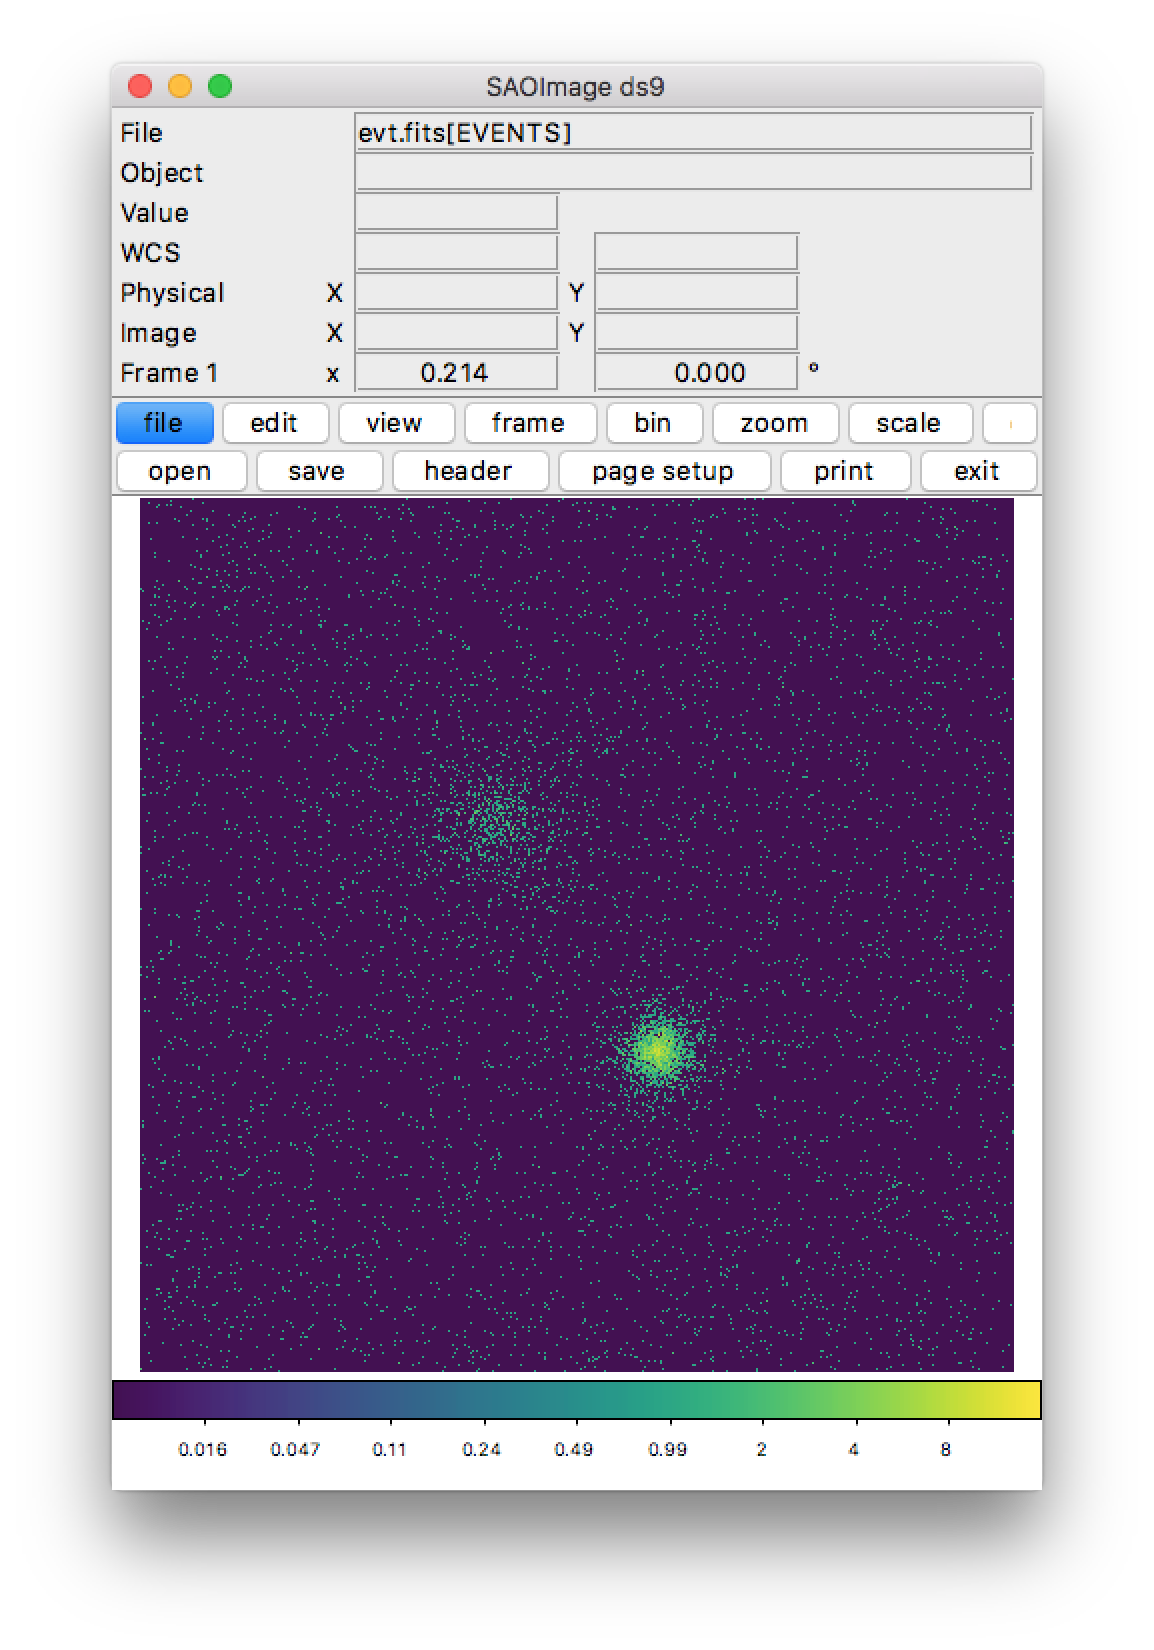

In [14]:
from IPython.display import Image
Image("../images/two_clusters.png")